In [4]:
import kagglehub

path = kagglehub.dataset_download("imdevskp/world-population-19602018")

print("Path to dataset files:", path)

Path to dataset files: /Users/flavio/.cache/kagglehub/datasets/imdevskp/world-population-19602018/versions/6


# LE 1 Performacne

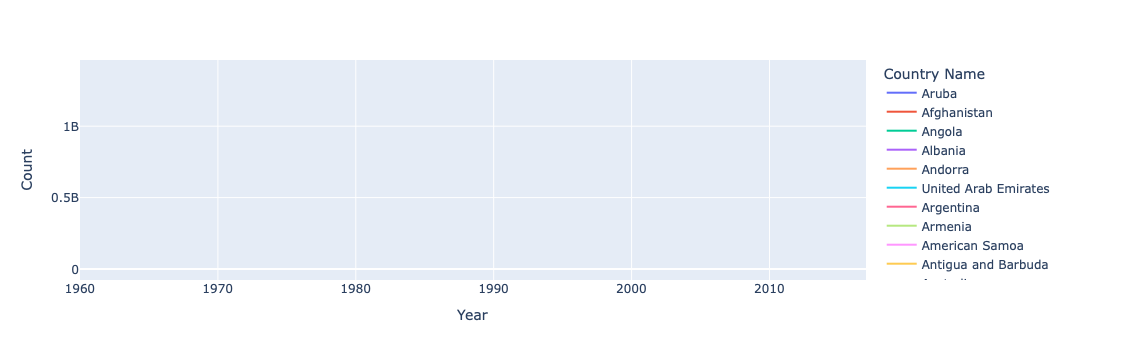

Alle Länder: 0.23 s


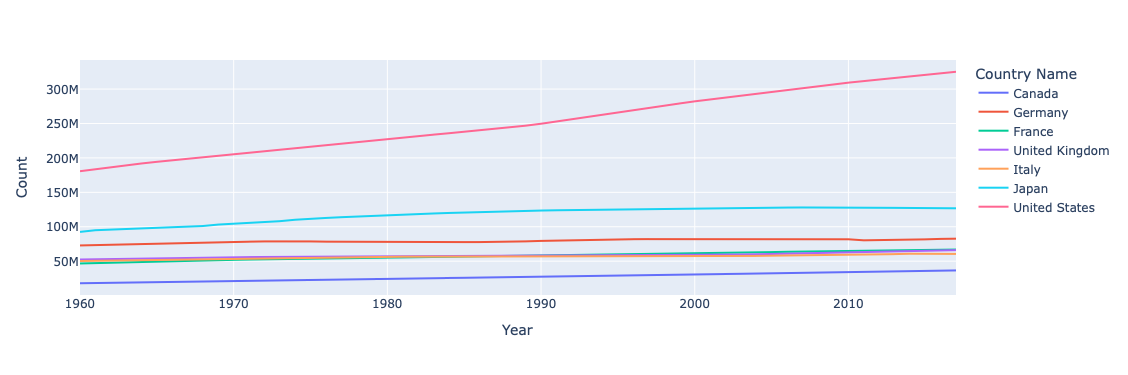

G7-Staaten: 0.02 s


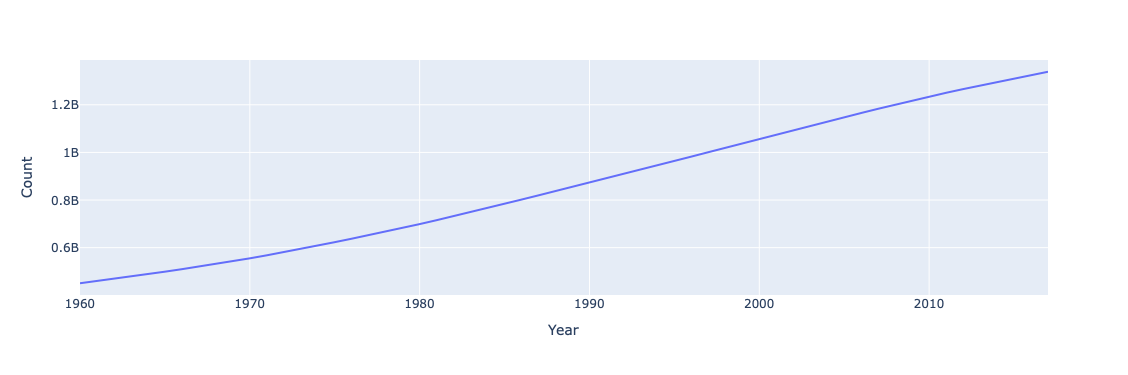

Nur Indien: 0.02 s


In [5]:
import pandas as pd
import plotly.express as px
import time

df = pd.read_csv(path+"/population_total_long.csv")

start = time.time()
fig = px.line(df, x="Year", y="Count", color="Country Name")
fig.show()
print("Alle Länder:", round(time.time() - start, 2), "s")

g7 = ["Germany", "France", "Italy", "Japan", "United Kingdom", "United States", "Canada"]
df_g7 = df[df["Country Name"].isin(g7)]
start = time.time()
fig = px.line(df_g7, x="Year", y="Count", color="Country Name")
fig.show()
print("G7-Staaten:", round(time.time() - start, 2), "s")

df_india = df[df["Country Name"] == "India"]
start = time.time()
fig = px.line(df_india, x="Year", y="Count")
fig.show()
print("Nur Indien:", round(time.time() - start, 2), "s")


In [11]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output
import time

df = pd.read_csv(path+"/population_total_long.csv")
df = df[df["Year"].between(1960, 2018)]
all_countries = sorted(df["Country Name"].unique())

selected_countries = all_countries.copy()

dropdown = widgets.Dropdown(
    options=all_countries,
    description="Land:"
)

add_button = widgets.Button(description="Hinzufügen", button_style='success')
remove_button = widgets.Button(description="Entfernen", button_style='warning')
clear_button = widgets.Button(description="Zurücksetzen", button_style='danger')
plot_button = widgets.Button(description="Visualisieren", button_style='info')

checkbox_output = widgets.Output()
plot_output = widgets.Output()

def update_checkboxes():
    checkbox_output.clear_output()
    with checkbox_output:
        global checkbox_list
        checkbox_list = widgets.SelectMultiple(
            options=selected_countries,
            value=tuple(selected_countries),
            description="Auswahl:",
            layout=widgets.Layout(width='50%', height='200px'),
            style={'description_width': 'initial'}
        )
        display(checkbox_list)

def add_country(b):
    country = dropdown.value
    if country not in selected_countries:
        selected_countries.append(country)
    update_checkboxes()

def remove_selected(b):
    for country in checkbox_list.value:
        if country in selected_countries:
            selected_countries.remove(country)
    update_checkboxes()

def clear_selection(b):
    selected_countries.clear()
    update_checkboxes()

def plot_selected(b):
    plot_output.clear_output()
    with plot_output:
        if not checkbox_list.value:
            print("Bitte mindestens ein Land auswählen.")
            return
        start = time.time()
        data = df[df["Country Name"].isin(checkbox_list.value)]
        fig = px.line(data, x="Year", y="Count", color="Country Name",
                      title=f"Bevölkerungsvergleich: {', '.join(checkbox_list.value)}")
        fig.show()
        print(f"Renderzeit: {round(time.time() - start, 2)} s")

add_button.on_click(add_country)
remove_button.on_click(remove_selected)
clear_button.on_click(clear_selection)
plot_button.on_click(plot_selected)

update_checkboxes()
display(widgets.HBox([dropdown, add_button, remove_button, clear_button]))
display(checkbox_output)
display(plot_button)
display(plot_output)


Output()

Button(button_style='info', description='Visualisieren', style=ButtonStyle())

Output()

In [20]:
import pandas as pd

base_path = path + "/"  

files = {
    "population_total": "population_total_long.csv",
    "population_density": "population_density_long.csv",
    "population_female": "population_female_percentage_long.csv",
    "population_below_14": "population_below_age_14_percentage_long.csv",
    "population_above_65": "population_above_age_65_percentage_long.csv"
}

dataframes = {}
for key, filename in files.items():
    df = pd.read_csv(base_path + filename)
    df.columns = df.columns.str.strip()

    df.rename(columns={"Count": key}, inplace=True)

    df = df[["Country Name", "Year", key]]
    dataframes[key] = df

df_merged = dataframes["population_total"]
for key in files:
    if key != "population_total":
        df_merged = df_merged.merge(dataframes[key], on=["Country Name", "Year"], how="left")

worldometer = pd.read_csv(base_path + "pop_worldometer_data.csv")
worldometer.columns = worldometer.columns.str.strip()
worldometer.rename(columns={"Country (or dependency)": "Country Name"}, inplace=True)

columns_to_keep = ["Country Name", "Population (2020)", "Density (P/Km²)", "Urban Pop %", "Med. Age"]
worldometer = worldometer[columns_to_keep]

final_df = df_merged.merge(worldometer, on="Country Name", how="left")

final_df = final_df.sort_values(by=["Country Name", "Year"])

print(final_df.head())

final_df.to_csv(base_path + "merged_population_data_final.csv", index=False)



    Country Name  Year  population_total  population_density  \
1    Afghanistan  1960           8996973                 NaN   
217  Afghanistan  1961           9169410                14.0   
433  Afghanistan  1962           9351441                14.0   
649  Afghanistan  1963           9543205                14.0   
865  Afghanistan  1964           9744781                14.0   

     population_female  population_below_14  population_above_65  \
1                 48.0                 42.0                  2.0   
217               48.0                 42.0                  2.0   
433               48.0                 42.0                  2.0   
649               48.0                 42.0                  2.0   
865               48.0                 42.0                  2.0   

     Population (2020)  Density (P/Km²)  Urban Pop %  Med. Age  
1           38928346.0             60.0         25.0      18.0  
217         38928346.0             60.0         25.0      18.0  
433        

In [31]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd

def display_side_by_side(fig1, fig2, width="48%"):
    html = f"""
    <div style="display: flex; justify-content: space-between;">
        <div style="width:{width}; padding-right: 1%;">{fig1.to_html(include_plotlyjs=False, full_html=False)}</div>
        <div style="width:{width}; padding-left: 1%;">{fig2.to_html(include_plotlyjs=False, full_html=False)}</div>
    </div>
    """
    return HTML(html)

def render_kpis(dff):
    if dff.empty:
        return HTML("<b>Keine Daten für Auswahl vorhanden.</b>")
    table = dff[["Country Name", "population_total", "population_density"]].copy()
    table.columns = ["Land", "Bevölkerung (total)", "Bevölkerungsdichte (Einw./km²)"]
    table["Bevölkerung (total)"] = table["Bevölkerung (total)"].round().astype(int)
    table["Bevölkerungsdichte (Einw./km²)"] = table["Bevölkerungsdichte (Einw./km²)"].round(1)
    return HTML(table.to_html(index=False))

def update_dashboard(selected_countries, selected_year):
    dff = df_merged[df_merged["Country Name"].isin(selected_countries)]
    dff_year = dff[dff["Year"] == selected_year]

    fig1 = px.choropleth(
        df_merged[df_merged["Year"] == selected_year],
        locations="Country Name",
        locationmode="country names",
        color="population_total",
        title="Weltbevölkerung",
        labels={"population_total": "Einwohner", "Country Name": "Land"},
        color_continuous_scale="Viridis",
        height=400
    )
    fig1.update_layout(margin=dict(l=0, r=0, t=40, b=0), plot_bgcolor="#f9f9f9")

    fig4 = px.line(
        dff,
        x="Year",
        y="population_total",
        color="Country Name",
        title="Bevölkerungsentwicklung",
        labels={"Year": "Jahr", "population_total": "Einwohner", "Country Name": "Land"},
        height=300
    )
    fig4.update_layout(plot_bgcolor="#f9f9f9")

    fig2 = px.bar(
        dff_year,
        x="Country Name",
        y=["population_below_14", "population_above_65"],
        title="Altersstruktur",
        labels={
            "Country Name": "Land",
            "value": "Anteil in %",
            "variable": "Altersgruppe"
        },
        height=300
    )
    fig2.update_layout(barmode="group", plot_bgcolor="#f9f9f9")

    fig3 = px.bar(
        dff_year,
        x="Country Name",
        y="population_density",
        title="Bevölkerungsdichte",
        labels={
            "Country Name": "Land",
            "population_density": "Einwohner pro km²"
        },
        height=300
    )
    fig3.update_layout(plot_bgcolor="#f9f9f9")

    display(widgets.HTML(f"<h2>Dashboard – Jahr {selected_year}</h2>"))
    display(render_kpis(dff_year))
    display(fig1)
    display(fig4)
    display(display_side_by_side(fig2, fig3))

all_countries = sorted(df_merged["Country Name"].dropna().unique())
country_select = widgets.SelectMultiple(
    options=all_countries,
    value=("Switzerland", "Germany"),
    description="Länder",
    layout=widgets.Layout(width="50%", height="180px")
)

year_slider = widgets.IntSlider(
    value=df_merged["Year"].max(),
    min=df_merged["Year"].min(),
    max=df_merged["Year"].max(),
    step=1,
    description='Jahr',
    continuous_update=False
)

ui = widgets.VBox([country_select, year_slider])
out = widgets.interactive_output(update_dashboard, {
    "selected_countries": country_select,
    "selected_year": year_slider
})

display(ui, out)


Output()